# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.


## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

---

# Import regular packages

In [1]:
%pip install -r /workspace/powdery_mildew_detector/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip freeze > requirements.all

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspace/powdery_mildew_detector')
print("You set a new current directory")

You set a new current directory


In [5]:

work_dir = os.getcwd()
work_dir

'/workspace/powdery_mildew_detector'

---

## Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [7]:
version = 'v9'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available create a new version.


## Set labels

In [8]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v9'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

          Set           Label  Frequency
0       train         healthy       1472
1       train  powdery_mildew       1472
2  validation         healthy        210
3  validation  powdery_mildew        210
4        test         healthy        422
5        test  powdery_mildew        422


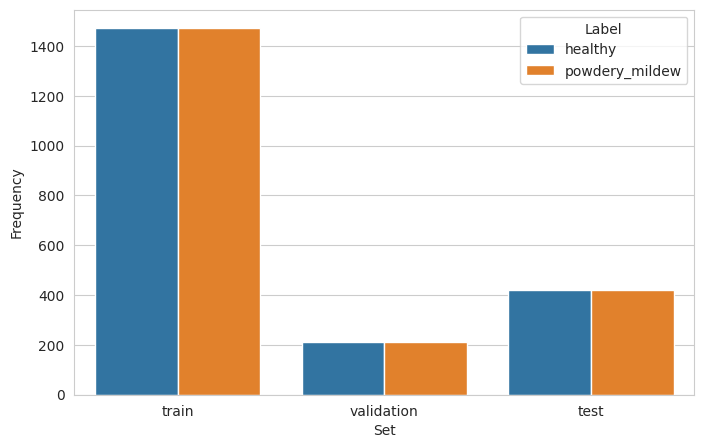

In [10]:
all_data = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        
        all_data.append({
            'Set': folder,
            'Label': label,
            'Frequency': num_images
        })

# Create the DataFrame in one go
df_freq = pd.DataFrame(all_data)

print(df_freq)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show() 

---

# Image data augmentation

---

### ImageDataGenerator

In [11]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-12 17:34:03.071564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [13]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

In [17]:
pip install scipy

  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.8 MB)
Note: you may need to restart the kernel to use updated packages.


(20, 256, 256, 3)


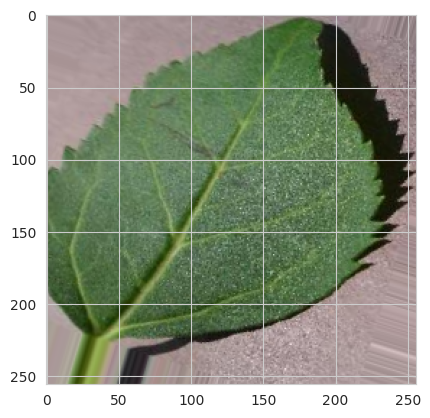

(20, 256, 256, 3)


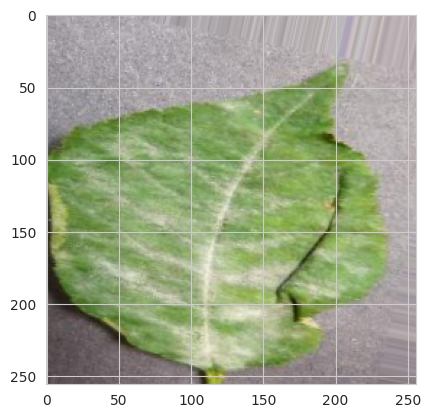

(20, 256, 256, 3)


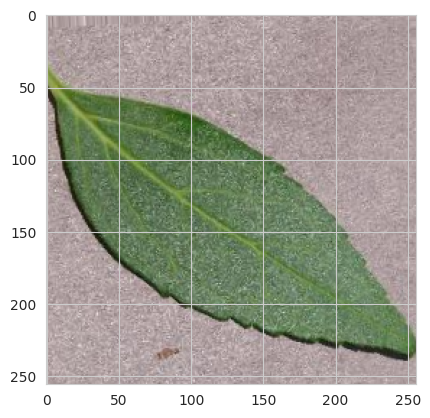

In [18]:
for _ in range(3):
    # img, label = train_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()
 


## Plot augmented validation and test images

(20, 256, 256, 3)


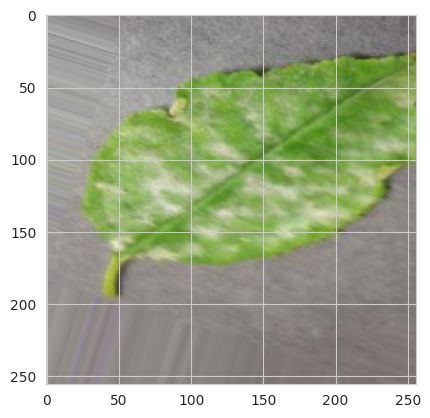

(20, 256, 256, 3)


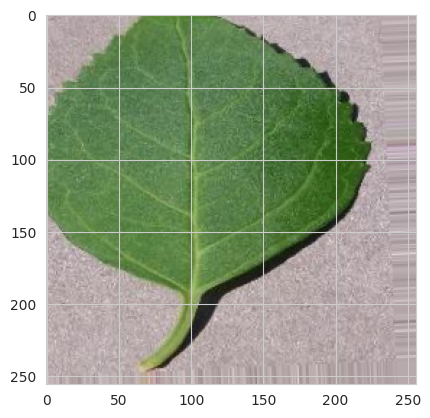

(20, 256, 256, 3)


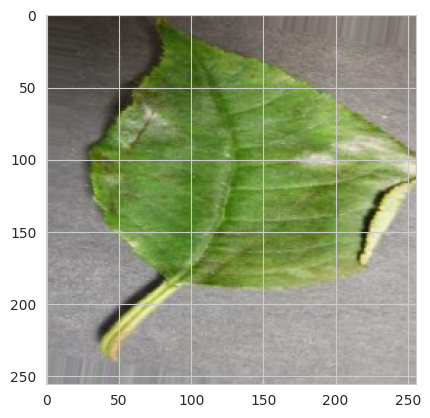

In [19]:
for _ in range(3):
    # img, label = validation_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 256, 256, 3)


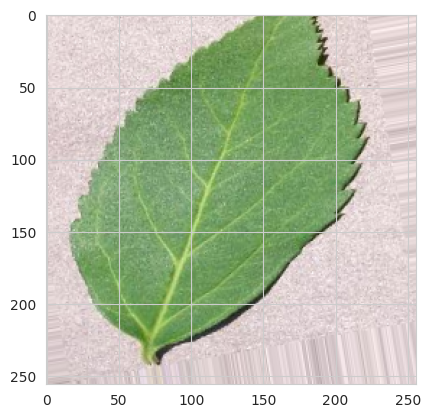

(20, 256, 256, 3)


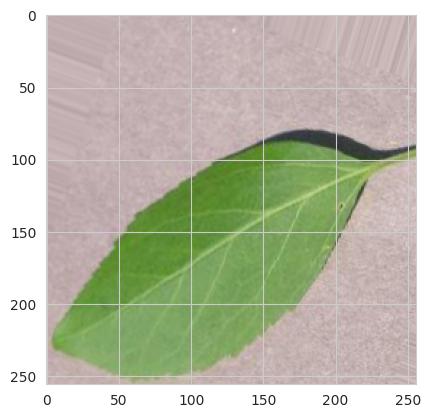

(20, 256, 256, 3)


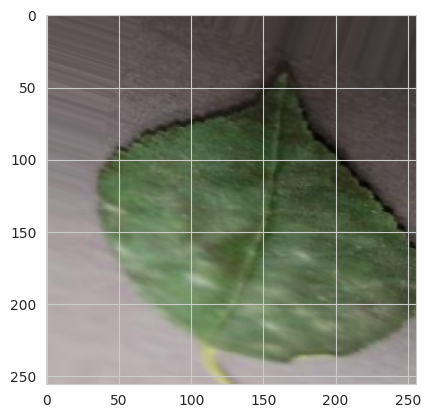

In [20]:
for _ in range(3):
    # img, label = test_set.next()
    img, label = next(iter(train_set))
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v9/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [23]:
def create_tf_model():
    
    model = Sequential()

    # model.add(Conv2D(filters=16, kernel_size=(3, 3),
    #          input_shape=image_shape, activation='relu', ))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model


* ### Model Summary 

In [24]:
create_tf_model().summary()

/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,610 (60.14 MB)

 Trainable params: 15,764,610 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

* ### Early Stopping 

In [262]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)


## Fit model for model training

In [263]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.7418 - loss: 0.7758 - val_accuracy: 0.9833 - val_loss: 0.0844
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.8500 - loss: 0.2750

/home/gitpod/.pyenv/versions/3.12.6/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.8500 - loss: 0.2750 - val_accuracy: 0.9833 - val_loss: 0.1165
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9650 - loss: 0.0903 - val_accuracy: 0.9643 - val_loss: 0.1496
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 1.0000 - loss: 0.0632 - val_accuracy: 0.9810 - val_loss: 0.1053
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9815 - loss: 0.0532 - val_accuracy: 0.9881 - val_loss: 0.0412
Epoch 6/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:26 1s/step - accuracy: 1.0000 - loss: 0.0447

2024-10-12 16:13:37.878748: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 1.0000 - loss: 0.0447 - val_accuracy: 0.9810 - val_loss: 0.0554
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9859 - loss: 0.0496 - val_accuracy: 0.9857 - val_loss: 0.0464
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 0.9857 - val_loss: 0.0454
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.9743 - loss: 0.0795 - val_accuracy: 0.9857 - val_loss: 0.0446
Epoch 10/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9857 - val_loss: 0.0584


## Save model

In [1]:
# model.save('outputs/v1/cherry_leaves_model.h5')
model.save('outputs/v9/cherry_leaves_model.keras')


NameError: name 'model' is not defined

---

# Model Performace

---

## Model learning curve

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Load saved model

In [ ]:
pip install scikit-learn

In [225]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from keras.models import load_model
# model = load_model('outputs/v1/cherry_leaves_model.h5')
model = load_model('outputs/v9/cherry_leaves_model.keras')

## Create a confusion Matrix

In [ ]:
validation_set.reset()


x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels


cm = confusion_matrix(y_true,y_pred)
sns_colours = sns.diverging_palette(20, 145, as_cmap=True)


classes=list(test_set.class_indices.keys())
length = len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=sns_colours)       
plt.xticks(np.arange(length) + .5, classes, rotation=0, fontsize=8)
plt.yticks(np.arange(length) + .3, classes, rotation=90, fontsize=8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()



Evaluate the model on the test set

In [227]:
best_model = load_model("outputs/v9/cherry_leaves_model.keras")

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy}")

## Calculate accuracy and generate predictions

Reset the test set iterator, calculates the true labels, and generates predictions for the test set.

In [ ]:
# Reset the test set iterator
test_set.reset()

# Generate predictions
y_true = test_set.classes
y_pred = best_model.predict(test_set, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

## Generate classification report - A

Generates and prints a standard classification report.

In [ ]:
general_report = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report for Model A:\n", general_report)

## Generate classification report - B

Generates a classification report and visualizes it as a heatmap

In [ ]:
classification_report_heatmap = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pd.DataFrame(classification_report_heatmap).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')
plt.savefig(f'{file_path}/classification_report_heatmap.png')
plt.show()

## Plot ROC curve

Plots and saves the ROC curve for each class in the test set.

In [ ]:
true_positive_rate = {}
false_positive_rate = {}
roc_auc = {}
for i, label in enumerate(labels):
    false_positive_rate[label], true_positive_rate[label], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[label] = auc(false_positive_rate[label], true_positive_rate[label])

plt.figure()
for label in labels:
    plt.plot(false_positive_rate[label], true_positive_rate[label], label=f'ROC curve (area = {roc_auc[label]:.2f}) for {label}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig(f'{file_path}/roc_curve.png')
plt.show()

Evaluate model on test set

In [ ]:
evaluation = model.evaluate(test_set)


### Save evaluation pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v9/evaluation.pkl")


## Predict on new data

Load a random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 199
label = labels[0]  # select healthy (0) or powdery mildew (1)  

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array and prepare for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

Predict class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

    


---

# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* .gitignore

In [ ]:
!cat .gitignore

* Git status

In [ ]:
!git status

* Git add

In [169]:
!git add .

* Git commit

In [ ]:
!git commit -am "New model v9" 


* Git Push

In [ ]:
!git push

---